In [9]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

# 加载数据
df = pd.read_csv("../complete_data.csv")

# 过滤未参赛国家（Gold/Silver/Bronze/Participants/Events全为0的行）
mask = (df[['Gold', 'Silver', 'Bronze', 'Participants', 'Events']].sum(axis=1) > 0) | (df['Year'] == 2024)
df = df[mask]

# 按国家和年份排序
df = df.sort_values(by=['NOC', 'Year'])

In [10]:
# 定义时间窗口（前三届）
WINDOW_SIZE = 3

# 按国家分组生成滞后特征
features = []
for _, group in df.groupby('NOC'):
    for lag in range(1, WINDOW_SIZE+1):
        # 滞后特征：奖牌、参赛人数、项目数、总奖牌数
        lagged = group.shift(lag)
        lag_cols = ['Gold', 'Silver', 'Bronze', 'Total', 'Participants', 'Events']
        lagged_features = lagged[lag_cols]
        lagged_features.columns = [f'lag{lag}_' + col for col in lag_cols]
        group = pd.concat([group, lagged_features], axis=1)
    features.append(group)

df = pd.concat(features)

# 特征矩阵：滞后特征 + 是否主办方
X = df.filter(regex='lag|is_host')

# 目标变量：当前届金牌数（可替换为Total/Silver/Bronze）
y = df['Gold']
# y = df['Total']

# 删除缺失值（前3届无数据）
df = df.dropna(subset=X.columns)
X = X.loc[df.index]
y = y.loc[df.index]

In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [12]:
tss = TimeSeriesSplit(n_splits=5)
maes = []

for train_idx, test_idx in tss.split(X_scaled):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # 训练Lasso模型（自动调优正则化强度alpha）
    model = LassoCV(cv=5, max_iter=10000)
    model.fit(X_train, y_train)

    # 评估
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    maes.append(mae)

print(f"平均MAE: {np.mean(maes):.2f}")

平均MAE: 1.17


In [14]:
# 特征重要性分析
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'coef': model.coef_
}).sort_values('coef', key=abs, ascending=False)

print("关键特征重要性：")
print(feature_importance.head(10))

# 预测2024年金牌数
df_2024 = df[df['Year'] == 2024]
X_2024 = scaler.transform(df_2024.filter(regex='lag|is_host'))
df_2024['Predicted_Gold'] = model.predict(X_2024)
df_2024[['NOC', 'Year', 'Predicted_Gold']].to_csv("2024_Gold_lasso.csv",index=False)

关键特征重要性：
              feature      coef
1           lag1_Gold  2.769035
7           lag2_Gold  0.942147
14        lag3_Silver  0.726836
0             is_host  0.652458
11  lag2_Participants  0.425994
4          lag1_Total  0.295617
10         lag2_Total  0.259529
15        lag3_Bronze -0.160180
6         lag1_Events  0.147772
12        lag2_Events  0.025980


C:\Users\31670\AppData\Local\Temp\ipykernel_2748\2475288192.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2024['Predicted_Gold'] = model.predict(X_2024)


In [8]:
tmp_df = pd.read_csv("2024_Total_lasso.csv")
tmp_df['Predicted_Total'] = max(tmp_df['Predicted_Total'],0)
summ = tmp_df['Predicted_Total'].sum()
tmp_df['Predicted_Total'] = tmp_df['Predicted_Total']/summ
tmp_df['Predicted_Total'] = int(tmp_df['Predicted_Total']*1019)
tmp_df.to_csv("2024_Total_lasso.csv",index=False)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [115]:
# 计算总和
import pandas as pd
df = pd.read_csv('lasso_pred.csv')
total_sum = df['Predicted_Total'].sum()
gold_sum = df['Predicted_Gold'].sum()

# 计算占比并添加新列
df['Total_Probability'] = df['Predicted_Total'] / total_sum
df['Gold_Probability'] = df['Predicted_Gold'] / gold_sum

# 输出结果
print(df)

# 保存结果到新的 CSV 文件
df.to_csv('predicted_probabilities.csv', index=False)

     NOC  Year  Predicted_Total  Predicted_Gold  Total_Probability  \
0    AFG  2024         0.266454        0.190002           0.000094   
1    AHO  2024         0.163978        0.150886           0.000058   
2    ALB  2024         0.469580        0.298201           0.000166   
3    ALG  2024         4.176923        1.142087           0.001474   
4    AND  2024         0.165318        0.109856           0.000058   
..   ...   ...              ...             ...                ...   
209  VNM  2024         0.306055        0.097159           0.000108   
210  YEM  2024         0.230996        0.192993           0.000082   
211  YUG  2024        46.605260       17.232557           0.016445   
212  ZAM  2024         1.208117        0.367198           0.000426   
213  ZIM  2024         1.173264        0.254661           0.000414   

     Gold_Probability  
0            0.000200  
1            0.000159  
2            0.000314  
3            0.001201  
4            0.000116  
..             

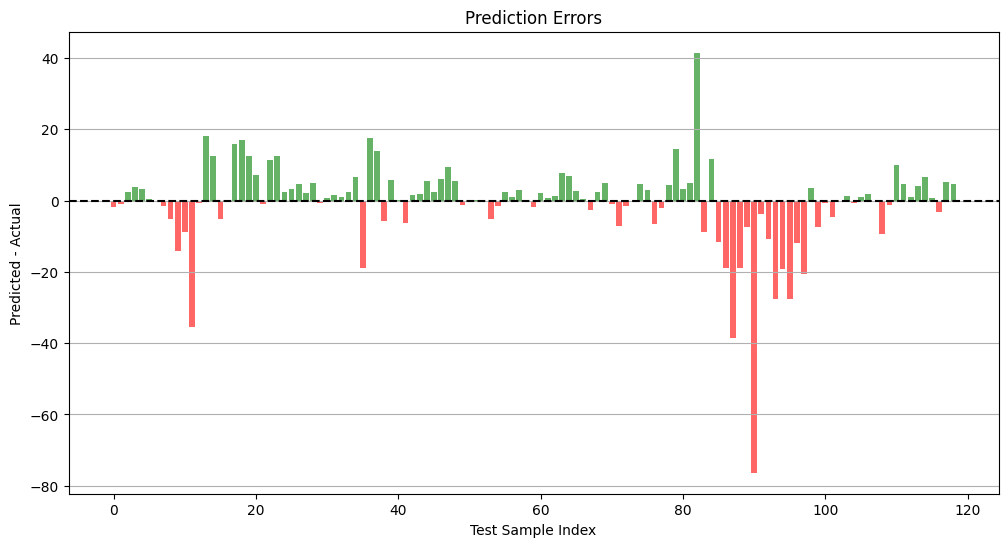

In [25]:
import matplotlib.pyplot as plt
import numpy as np
y_true = y_test
y_pred = model.predict(X_test)  # 请确保此行在你的上下文中有效
# 假设 test_error 是一个包含预测值与真实值之间差异的列表
# test_error = [误差1, 误差2, 误差3, ..., 误差n]
test_error = y_pred - y_true
# 创建颜色数组，根据误差决定颜色
colors = ['green' if error > 0 else 'red' for error in test_error]

# 绘制误差图
plt.figure(figsize=(12, 6))
plt.bar(range(len(test_error)), test_error, color=colors, alpha=0.6)
plt.axhline(0, color='black', linestyle='--')  # 添加零误差参考线
plt.title('Prediction Errors')
plt.xlabel('Test Sample Index')
plt.ylabel('Predicted - Actual')
# plt.xticks(range(len(test_error)))  # 根据误差数量设置x轴刻度
plt.grid(axis='y')  # 添加y轴网格
plt.show()

In [19]:
print(type(difference))

<class 'pandas.core.series.Series'>


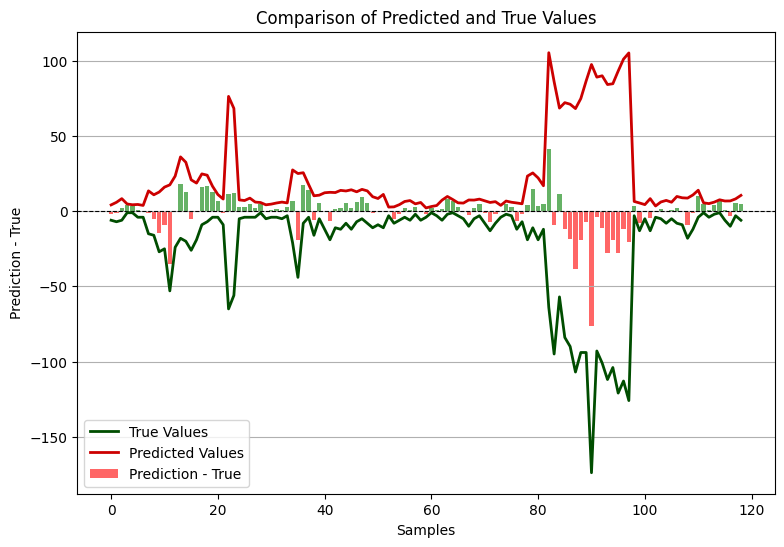

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

# Set font to support English without warnings
# matplotlib.rcParams['font.family'] = 'DejaVu Sans'

# Example data (假设 y_pred 和 y_test 已经定义)
y_true = y_test
y_pred = model.predict(X_test)  # 请确保此行在你的上下文中有效

# Calculate the difference
difference = y_pred - y_true

# Create figure with a specific size
plt.figure(figsize=(9, 6))  # 设置图形大小
colors = ['green' if error > 0 else 'red' for error in test_error]
# Create bar chart with unified color
plt.bar(range(len(difference)), difference, color=colors, alpha=0.6, label='Prediction - True')

# Add labels and title
plt.xlabel('Samples')
plt.ylabel('Prediction - True')
plt.title('Comparison of Predicted and True Values')

# Add horizontal reference line
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')

# Plot the true values and predicted values as lines
plt.plot(range(len(y_true)), -1 * y_true, color='#004d00', label='True Values', linestyle='-', linewidth=2)  # 深绿色
plt.plot(range(len(y_pred)), y_pred, color='#cc0000', label='Predicted Values', linestyle='-', linewidth=2)  # 深红色

# Add legends
plt.legend()

# Add grid for better readability
plt.grid(axis='y')  # 添加y轴网格
plt.show()

C:\Users\31670\AppData\Local\Temp\ipykernel_36116\2856244763.py:31: UserWarning: Glyph 36724 (\N{CJK UNIFIED IDEOGRAPH-8F74}) missing from font(s) DejaVu Sans.
  fig.tight_layout()  # 自动调整布局
C:\Users\31670\AppData\Local\Temp\ipykernel_36116\2856244763.py:31: UserWarning: Glyph 24038 (\N{CJK UNIFIED IDEOGRAPH-5DE6}) missing from font(s) DejaVu Sans.
  fig.tight_layout()  # 自动调整布局
C:\Users\31670\AppData\Local\Temp\ipykernel_36116\2856244763.py:31: UserWarning: Glyph 20391 (\N{CJK UNIFIED IDEOGRAPH-4FA7}) missing from font(s) DejaVu Sans.
  fig.tight_layout()  # 自动调整布局
C:\Users\31670\AppData\Local\Temp\ipykernel_36116\2856244763.py:31: UserWarning: Glyph 21491 (\N{CJK UNIFIED IDEOGRAPH-53F3}) missing from font(s) DejaVu Sans.
  fig.tight_layout()  # 自动调整布局
C:\Users\31670\AppData\Local\Temp\ipykernel_36116\2856244763.py:31: UserWarning: Glyph 22797 (\N{CJK UNIFIED IDEOGRAPH-590D}) missing from font(s) DejaVu Sans.
  fig.tight_layout()  # 自动调整布局
C:\Users\31670\AppData\Local\Temp\ipykernel_3

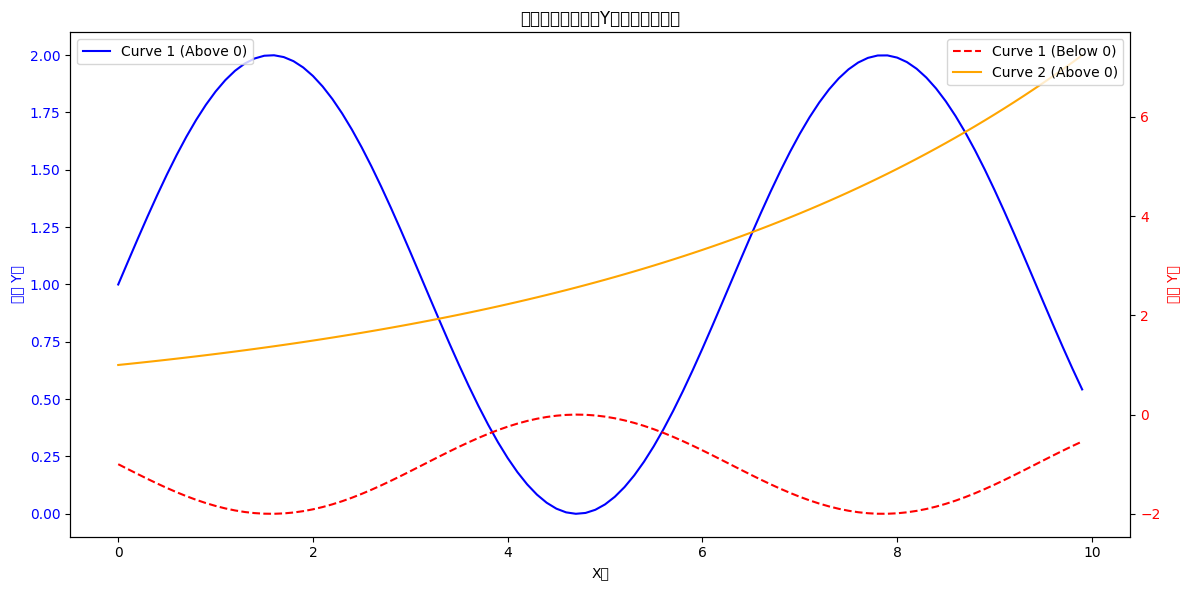

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# 示例数据
x = np.arange(0, 10, 0.1)

# 两条曲线的数据，均大于0
y1 = np.sin(x) + 1  # 第一条曲线，始终大于 0
y2 = np.exp(x / 5)  # 第二条曲线，也始终大于 0

# 创建图形和主坐标轴
fig, ax1 = plt.subplots(figsize=(12, 6))

# 绘制左侧y轴的数据
ax1.plot(x, y1, color='blue', label='Curve 1 (Above 0)')
ax1.set_xlabel('X轴')
ax1.set_ylabel('左侧 Y轴', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# 创建右侧y轴
ax2 = ax1.twinx()  # 实现双y轴

# 绘制右侧y轴的数据
ax2.plot(x, -y1, color='red', label='Curve 1 (Below 0)', linestyle='--')  # 将y1乘以-1
ax2.plot(x, y2, color='orange', label='Curve 2 (Above 0)', linestyle='-')  # 第二条曲线
ax2.set_ylabel('右侧 Y轴', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# 添加标题和图例
plt.title('复合图示例：右侧Y轴显示两条曲线')
fig.tight_layout()  # 自动调整布局

# 添加图例
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()